# Explore latent representations of symbols

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

sys.path.append('../../modules/')

from logger_tree_language import get_logger
from pytorch_utilities import load_checkpoint
from plotting import plot_training_history
from masked_language_modeling import mask_sequences

sns.set_theme()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

logger = get_logger('check_mlm_performance')

In [2]:
PRETRAINING_DATA_PATH = '../../data/mlm_data/slrm_data/labeled_data_fixed_4_8_1.0_0.00000.npy'
DATA_PATH = '../../data/mlm_data/slrm_data/labeled_data_fixed_validation_4_8_1.0_0.00000.npy'
MODEL_DIR = '../../models/mlm_pretraining_2/'

Load pretrained model.

In [3]:
checkpoint_epochs = sorted([
    int(f.split('_')[-1].split('.')[0])
    for f in os.listdir(MODEL_DIR)
    if '.pt' in f
])

selected_checkpoint_epoch = checkpoint_epochs[-1]

checkpoint_id = [f for f in os.listdir(MODEL_DIR) if f'{selected_checkpoint_epoch}.pt' in f][0]

logger.info(f'Selected checkpoint: {checkpoint_id}')

pretrained_model, _, pretraining_history = load_checkpoint(
    MODEL_DIR,
    checkpoint_id,
    device=device
)

2024-05-21 15:10:33,808 - check_mlm_performance - INFO - Selected checkpoint: mlm_pretraining_2_epoch_2000.pt
/home/moscato/miniconda3/envs/tree-language/lib/python3.10/site-packages/torch/nn/modules/transformer.py:286: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Load data.

In [4]:
q, k, sigma, epsilon, roots_seeds, leaves_seeds, rho_seeds = np.load(DATA_PATH, allow_pickle=True)

# The last index corresponds to the seed that generated the
# data/transition tensors: select one.
seed = 0

shuffled_indices = np.random.choice(range(leaves_seeds.shape[1]), leaves_seeds.shape[1], replace=False)

roots = roots_seeds[:, seed]
roots = roots[shuffled_indices]

leaves = leaves_seeds[..., seed].T
leaves = leaves[shuffled_indices, :]
rho = rho_seeds[..., seed]

# Train-test split.
n_samples_test = 5000

leaves_train = leaves[:-n_samples_test, :]
roots_train = roots[:-n_samples_test]

leaves_test = leaves[-n_samples_test:, :]
roots_test = roots[-n_samples_test:]

logger.info(
    f'N training samples: {leaves_train.shape[0]}'
    f' | N test samples: {leaves_test.shape[0]}'
)

# Data preprocessing.
leaves_train = torch.from_numpy(leaves_train).to(device=device).to(dtype=torch.int64)
leaves_test = torch.from_numpy(leaves_test).to(device=device).to(dtype=torch.int64)

roots_train = torch.from_numpy(roots_train).to(device=device).to(dtype=torch.int64)
roots_test = torch.from_numpy(roots_test).to(device=device).to(dtype=torch.int64)

2024-05-21 15:10:35,267 - check_mlm_performance - INFO - N training samples: 45000 | N test samples: 5000


In [5]:
pretrained_model.transformer_encoder

TransformerEncoder(
  (layers): ModuleList(
    (0-1): 2 x TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=256, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=256, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
  )
)

In [6]:
activation = {}

def get_activation(name):
    def hook(model, input_data, output_data):
        activation[name] = output_data.detach()

    return hook

pretrained_model.transformer_encoder.register_forward_hook(get_activation('transformer_encoder'))

In [7]:
output = pretrained_model(leaves_test)

In [8]:
# Shape: (batch_shape, seq_len, hidden_dim) = (5000, 256, 128).
latent_vectors = activation['transformer_encoder']

latent_vectors

tensor([[[-1.1637,  0.5144, -0.0561,  ..., -1.2707,  1.0926,  0.6381],
         [-0.9539, -0.1624, -0.1200,  ..., -1.3081, -0.7884, -0.1283],
         [ 0.3958, -0.6798, -0.1476,  ..., -1.1418,  0.2956, -0.6436],
         ...,
         [ 0.8485, -0.4848, -0.2861,  ..., -0.7169,  0.4663, -0.2744],
         [ 0.1073,  0.1187, -1.4891,  ..., -0.2830, -0.3875, -0.3607],
         [-0.0703, -0.3606, -0.3579,  ...,  0.3456,  0.5346,  0.2723]],

        [[ 0.4460,  0.9124, -0.5172,  ..., -0.9455,  1.1176,  0.6822],
         [-0.3803,  0.0157,  0.8409,  ...,  0.8188,  1.1111,  0.0769],
         [ 0.4138, -2.0003, -0.3037,  ..., -0.1694,  3.1412, -0.2552],
         ...,
         [-0.5681,  0.1125, -0.8873,  ..., -1.6202,  0.8484,  0.8886],
         [-0.2552,  0.0602,  1.1883,  ...,  0.4065,  0.1790,  0.0607],
         [-1.3146, -0.2807, -0.3264,  ..., -0.5894,  0.7409,  0.3693]],

        [[ 1.0605,  0.0679, -1.0851,  ...,  0.3062,  0.0859, -0.6510],
         [ 0.5381, -0.6219, -0.1963,  ..., -0

In [9]:
# Total number of latent vectors: batch_shape * seq_len.
latent_vectors_symbols = {
    # Shape: (n_symbols, latent_dim), where n_symbols is the
    #        total number of times symbol i appears across all
    #        sequences.
    i: latent_vectors[(leaves_test == i), :].cpu().numpy()
    for i in range(q)
}

In [10]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [11]:
dim_red_model = PCA(n_components=2)
# dim_red_model = TSNE(n_components=2)

reduced_latent_vectors = dim_red_model.fit_transform(
    np.vstack([
        latent_vectors_symbols[i]
        for i in range(q)
    ])
)

reduced_latent_vectors = {
    i: (
        reduced_latent_vectors[latent_vectors_symbols[i-1].shape[0]:latent_vectors_symbols[i-1].shape[0] + latent_vectors_symbols[i].shape[0]]
        if i > 0 else reduced_latent_vectors[:latent_vectors_symbols[i].shape[0]]
    )
    for i in range(q)
}

Text(0, 0.5, 'Reduced dim. 2')

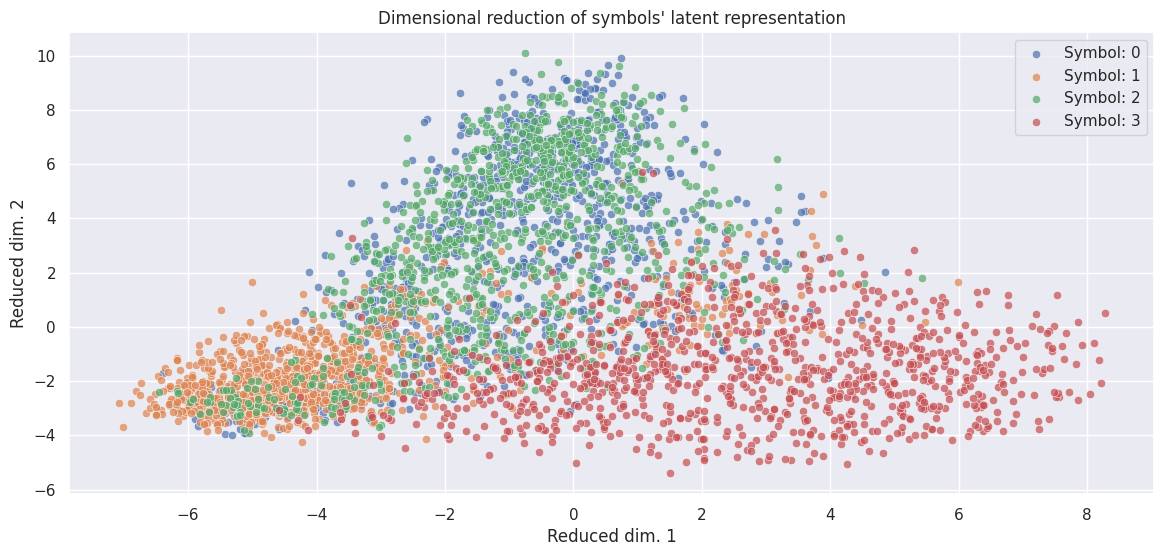

In [12]:
fig = plt.figure(figsize=(14, 6))

for i in range(q):
    sns.scatterplot(
        x=reduced_latent_vectors[i][:1000, 0],
        y=reduced_latent_vectors[i][:1000, 1],
        color=sns.color_palette()[i],
        label=f'Symbol: {i}',
        alpha=.7
    )

plt.title("Dimensional reduction of symbols' latent representation")
plt.xlabel('Reduced dim. 1')
plt.ylabel('Reduced dim. 2')